In [63]:
import torch
import torch.nn as nn
import scipy
import timeit
from matplotlib.path import Path
import pickle
from torch.distributions import MultivariateNormal

from tqdm import tqdm
import numpy as np
from plots import *

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# **1.** Plotting functions

In [67]:
def plot_pdf(pdf, grid_size=100, left_bound=-10, right_bound=10, title=None):
    nx, ny = grid_size, grid_size
    xs = torch.linspace(left_bound, right_bound, nx)
    ys = torch.linspace(left_bound, right_bound, ny)
    x, y = torch.meshgrid(xs, ys, indexing='xy')

    print("Computing density values...")
    densities = torch.zeros(x.shape)
    for i in tqdm(range(nx)):
        for j in range(ny):
            point = torch.tensor([x[j, i], y[j, i]])
            densities[j, i] = pdf(point)

    plt.imshow(densities.detach().numpy(), cmap='rocket', origin='lower')
    plt.axis('off')
    if title is None:
        title = 'True density'
    plt.title(title)


def plot_samples(samples, grid_size=100, left_bound=-10, right_bound=10, title=None):
    nx, ny = grid_size, grid_size
    xs = torch.linspace(left_bound, right_bound, nx)
    ys = torch.linspace(left_bound, right_bound, ny)

    x_idxs = torch.bucketize(samples[:, 0], xs[1:])
    y_idxs = torch.bucketize(samples[:, 1], ys[1:])

    densities = torch.zeros((grid_size, grid_size))
    for sample_idx in range(len(samples)):
        x_idx = x_idxs[sample_idx]
        y_idx = y_idxs[sample_idx]
        densities[y_idx, x_idx] += 1
        
    densities /= len(samples)

    plt.imshow(densities.detach().numpy(), cmap='rocket',origin='lower')
    plt.axis('off')
    if title is None:
        title = f'Samples density ({len(samples)} samples)'
    plt.title(title)

# **2.** Toy dataset: GMM

In [31]:
class GMM:
    def __init__(self, means, covs, weights):
        self.means = torch.tensor(means, dtype=torch.float64)     # [n_components, dimension]
        self.covs = torch.tensor(covs, dtype=torch.float64)       # [n_components, dimension, dimension]
        self.weights = torch.tensor(weights, dtype=torch.float64) # [n_components

    def sample(self, n):

        choices = torch.multinomial(self.weights, n, replacement=True)
        samples = torch.zeros((n, len(self.means[0])), dtype=torch.float64)

        for idx in np.arange(len(self.weights)):
            idxs = torch.where(choices == idx)[0]
            gm = MultivariateNormal(self.means[idx], self.covs[idx])
            g_samples = gm.sample((len(idxs), ))
            samples[idxs] = g_samples
            
        return samples

    def pdf(self, x):
        pdf_values = torch.stack([
            MultivariateNormal(self.means[i], self.covs[i]).log_prob(x).exp() 
            for i in range(len(self.means))
        ])
        result = torch.dot(pdf_values, self.weights)
        return result

    def log_prob(self, x):
        return self.pdf(x).log()

## **2.1** Toy dataset parameters

In [32]:
# toy dataset paramerts
val = 5
means = np.array([[-val, -val], [-val, val], [val, val],  [val, -val]])
covs = np.array([alpha * np.identity(2) for alpha in [10, 5, 12, 6]])
weights = [0.1,  0.3, 0.2, 0.4]

gmm = GMM(means, covs, weights)

## **2.2** Visualisation

Computing density values...
torch.Size([100, 100])


100%|██████████| 100/100 [00:04<00:00, 22.30it/s]


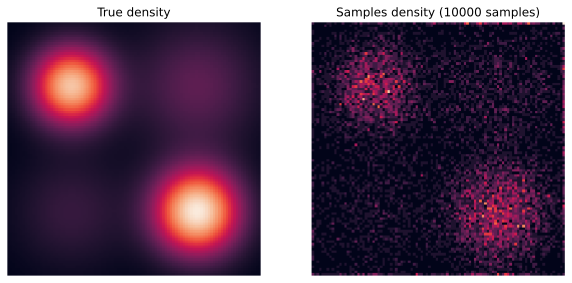

In [33]:
samples = gmm.sample(10000)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1) 
plot_pdf(gmm.pdf, left_bound=-10, right_bound=10)

plt.subplot(1, 2, 2)  
plot_samples(samples, left_bound=-10, right_bound=10)

# **3.** Sliced score matching with variance reduction

In [35]:
# define score architecture
hidden_units = 128
score = nn.Sequential(
            nn.Linear(2, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, 2),
        )

## **3.1** Objective function (SSM-VR)

In [36]:
def sliced_score_estimation_vr(score_net, samples, n_particles=1):
    dup_samples = samples.unsqueeze(0).expand(n_particles, *samples.shape).contiguous().view(-1, *samples.shape[1:])
    dup_samples.requires_grad_(True)
    vectors = torch.randn_like(dup_samples)

    grad1 = score_net(dup_samples)
    gradv = torch.sum(grad1 * vectors)
    grad2 = torch.autograd.grad(gradv, dup_samples, create_graph=True)[0]

    grad1 = grad1.view(dup_samples.shape[0], -1)
    loss1 = torch.sum(grad1 * grad1, dim=-1) / 2.

    loss2 = torch.sum((vectors * grad2).view(dup_samples.shape[0], -1), dim=-1)

    loss1 = loss1.view(n_particles, -1).mean(dim=0)
    loss2 = loss2.view(n_particles, -1).mean(dim=0)

    loss = loss1 + loss2
    return loss.mean(), loss1.mean(), loss2.mean()

## **3.2** Training

In [77]:
optimizer = torch.optim.Adam(score.parameters(), lr=0.001)

best_loss = float('inf')
best_weights = None
for step in range(40000):

    samples = gmm.sample(128)
    samples = samples.to(torch.float32)

    loss, *_ = sliced_score_estimation_vr(score, samples, n_particles=1)

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_weights = {param_name: param.clone().detach() for param_name, param in score.named_parameters()}

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

if best_weights is not None:
    score.load_state_dict(best_weights)

step: 0, loss: -0.12404340505599976
step: 1000, loss: -0.1603638082742691
step: 2000, loss: -0.14354181289672852
step: 3000, loss: -0.13275179266929626
step: 4000, loss: -0.12292756885290146
step: 5000, loss: -0.11870924383401871
step: 6000, loss: -0.1332729309797287
step: 7000, loss: -0.09451815485954285
step: 8000, loss: -0.10669511556625366
step: 9000, loss: -0.11166418343782425
step: 10000, loss: -0.1346396654844284
step: 11000, loss: -0.15317057073116302
step: 12000, loss: -0.11015791445970535
step: 13000, loss: -0.10235408693552017
step: 14000, loss: -0.12570442259311676
step: 15000, loss: -0.06257376074790955
step: 16000, loss: -0.12866155803203583
step: 17000, loss: -0.08037059009075165
step: 18000, loss: -0.15086540579795837
step: 19000, loss: -0.17526276409626007
step: 20000, loss: -0.09654182195663452
step: 21000, loss: -0.13593252003192902
step: 22000, loss: -0.1230408102273941
step: 23000, loss: -0.0980696976184845
step: 24000, loss: -0.07280009239912033
step: 25000, loss:

# **4.** Sampling

## **4.1** Langevin dynamics

In [78]:
# sample using langevin
def langevin_dynamics(score, init, lr=0.1, step=1000):
    for i in range(step):
        current_lr = lr
        init = init + current_lr / 2 * score(init).detach()
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

In [131]:
left_bound = -10
right_bound = 10
langevin_samples = torch.rand(10000, 2) * (right_bound - left_bound) + left_bound
langevin_samples = langevin_dynamics(score, langevin_samples)

In [132]:
print(samples.shape)
print(langevin_samples.shape)

torch.Size([10000, 2])
torch.Size([10000, 2])


Computing density values...


100%|██████████| 500/500 [01:46<00:00,  4.68it/s]


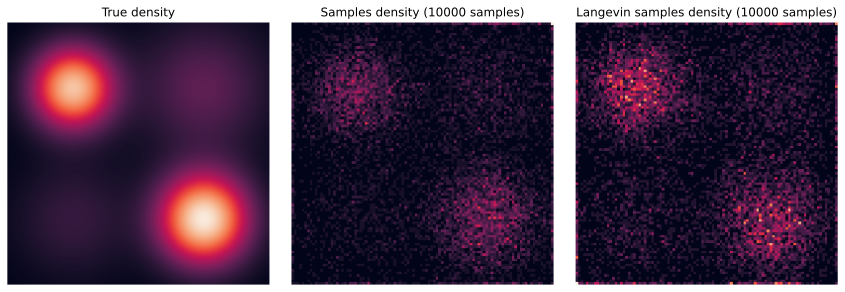

In [133]:
samples = gmm.sample(10000)

fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1) 
plot_pdf(gmm.pdf, grid_size=500, left_bound=-10, right_bound=10)

plt.subplot(1, 3, 2)  
plot_samples(samples, grid_size=100, left_bound=-10, right_bound=10)

plt.subplot(1, 3, 3)  
plot_samples(langevin_samples, grid_size=100, left_bound=-10, right_bound=10, title=f"Langevin samples density ({len(langevin_samples)} samples)")

fig.tight_layout()
plt.savefig("langevin.png", dpi=300)

# **5.** Execution time

In [82]:
def model(dimension):
    hidden_units = int(dimension * 10)
    score = nn.Sequential(
                nn.Linear(dimension, hidden_units),
                nn.Softplus(),
                nn.Linear(hidden_units, hidden_units),
                nn.Softplus(),
                nn.Linear(hidden_units, dimension),
            )
    
    return score

def measure_time(dimension, objective_function, n, verbose=False):
    score_net = model(dimension)
    x = torch.randn((128, dimension))
    def wrapper():
        return objective_function(score_net, x)
    execution_time = timeit.timeit(wrapper, number=n) / n

    if verbose:
        print(f"Execution time: {execution_time} seconds")

    return execution_time

In [83]:
def score_matching_objective(score_net, samples):
    samples.requires_grad_(True)
    grad1 = score_net(samples)
    loss1 = (torch.norm(grad1, dim=-1) ** 2 / 2.).detach()

    loss2 = torch.zeros(samples.shape[0])
    for i in range(samples.shape[1]):
        grad1 = score_net(samples)
        grad = torch.autograd.grad(grad1[:, i].sum(), samples)[0][:, i]
        loss2 += grad.detach()

    loss = loss1 + loss2
    return loss.mean()

Heavy computation in next cell, better skip and load saved lists (see below)

In [84]:
# t1 = []
# for i in tqdm([el * 10 for el in range(1, 100)]):
#     t1.append(measure_time(i, score_matching_objective, 1))

# t2 = []
# for i in tqdm([el * 10 for el in range(1, 100)]):
#     t2.append(measure_time(i, sliced_score_estimation_vr, 1))

# with open('results/t1.pkl', 'wb') as file:
#     pickle.dump(t1, file)

# with open('results/t2.pkl', 'wb') as file:
#     pickle.dump(t2, file)

In [85]:
with open('results/t1.pkl', 'rb') as file:
    t1 = pickle.load(file)

with open('results/t2.pkl', 'rb') as file:
    t2 = pickle.load(file)

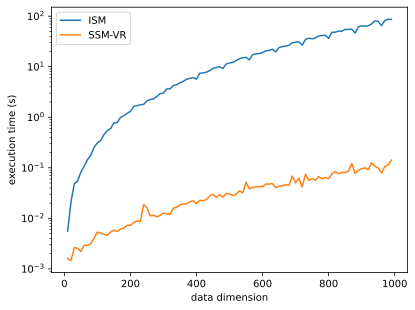

In [86]:
plt.plot([el * 10 for el in range(1, 100)], t1, label="ISM")
plt.plot([el * 10 for el in range(1, 100)], t2, label="SSM-VR")
plt.xlabel("data dimension")
plt.ylabel('execution time (s)')
plt.yscale('log')
plt.legend()
plt.savefig("execution_time.png", dpi=300)

# **6.** Low density limitations

In [87]:
def data_score(x, model):
    x = x.detach()
    x.requires_grad_(True)
    y = model.log_prob(x)
    return torch.autograd.grad(y, x)[0]

In [88]:
# compute true score vs estimated score

left_bound = -10
right_bound = 10
nx = 500
ny = 500

xs = torch.linspace(left_bound, right_bound, nx)
ys = torch.linspace(left_bound, right_bound, ny)
x, y = torch.meshgrid(xs, ys, indexing='xy')

densities = torch.zeros(x.shape)
estimated_score = torch.zeros((*x.shape, 2))
true_score = torch.zeros((*x.shape, 2))

for i in tqdm(range(nx)):
    for j in range(ny):
        point = torch.tensor([x[j, i], y[j, i]])
        estimated_score[j, i] = score(point.detach())
        densities[j, i] = gmm.pdf(point)
        true_score[j, i] = data_score(point, gmm)

distances = (estimated_score - true_score).norm(dim=2)

100%|██████████| 500/500 [04:59<00:00,  1.67it/s]


Computing density values...


100%|██████████| 10000/10000 [00:06<00:00, 1443.31it/s]


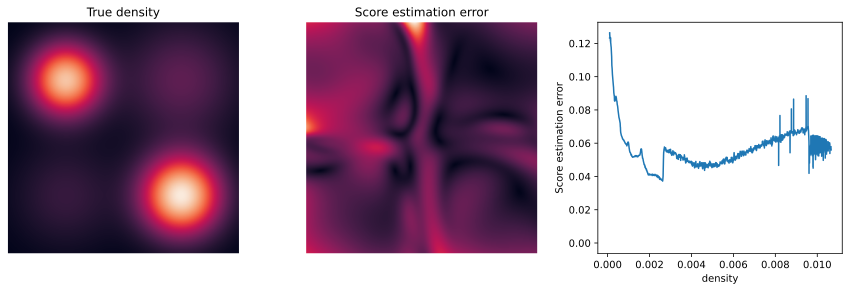

In [89]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1) 
plot_pdf(gmm.pdf, grid_size=500, left_bound=-10, right_bound=10)

# Plotting distances
plt.subplot(1, 3, 2)  # 1 row, 2 columns, second plot
plt.imshow(distances.detach().numpy(), cmap='rocket', origin='lower')
plt.axis('off')
plt.title('Score estimation error')

densities_flat = densities.flatten()
distances_flat = distances.flatten()

n_bins = 10000
bin_edges = torch.linspace(densities_flat.min(), densities_flat.max(), n_bins+1)
bin_idxs = torch.bucketize(densities_flat, bin_edges[1:])

mean_dens = []
mean_error = []
for i in tqdm(range(n_bins)):
    idxs = torch.where(bin_idxs == i)[0]
    dens = densities_flat[idxs]
    dists = distances_flat[idxs]
    mean_dens.append(dens.mean().detach().numpy())
    mean_error.append(dists.mean().detach().numpy())

plt.subplot(1, 3, 3)  # 1 row, 2 columns, second plot
plt.plot(mean_dens, scipy.signal.medfilt(mean_error, kernel_size=61))
plt.xlabel('density')
plt.ylabel('Score estimation error')

fig.tight_layout()
plt.savefig("error.png", dpi=300)

# **7.** Noise conditional score network, effect on score estimation error

## **7.1** Toy dataset parameters

In [ ]:
# toy dataset paramerts
means = np.array([[0, 0]])
covs = np.array([alpha * np.identity(2) for alpha in [5]])
weights = [1]

gmm = GMM(means, covs, weights)

## **7.2** Visualisation

Computing density values...


100%|██████████| 500/500 [00:31<00:00, 15.83it/s]


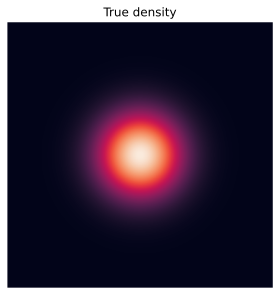

In [ ]:
plot_pdf(gmm.pdf, grid_size=500, left_bound=-10, right_bound=10)
plt.savefig("density.png", dpi=300)

In [ ]:
def data_score(x, model):
    x = x.detach()
    x.requires_grad_(True)
    y = model.log_prob(x)
    return torch.autograd.grad(y, x)[0]

In [ ]:
def anneal_sliced_score_estimation_vr(scorenet, samples, labels, sigmas, n_particles=1):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    dup_samples = perturbed_samples.unsqueeze(0).expand(n_particles, *samples.shape).contiguous().view(-1,
                                                                                                       *samples.shape[
                                                                                                        1:])
    dup_labels = labels.unsqueeze(0).expand(n_particles, *labels.shape).contiguous().view(-1)
    dup_samples.requires_grad_(True)

    # use Rademacher
    vectors = torch.randn_like(dup_samples)

    grad1 = scorenet(dup_samples, dup_labels)
    gradv = torch.sum(grad1 * vectors)
    grad2 = torch.autograd.grad(gradv, dup_samples, create_graph=True)[0]

    grad1 = grad1.view(dup_samples.shape[0], -1)
    loss1 = torch.sum(grad1 * grad1, dim=-1) / 2.

    loss2 = torch.sum((vectors * grad2).view(dup_samples.shape[0], -1), dim=-1)

    loss1 = loss1.view(n_particles, -1).mean(dim=0)
    loss2 = loss2.view(n_particles, -1).mean(dim=0)

    loss = (loss1 + loss2) * (used_sigmas.squeeze() ** 2)

    return loss.mean(dim=0)

In [ ]:
sigma_begin = 1
sigma_end =  0.01
num_classes = 10

sigmas = torch.tensor(np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end),num_classes))).float()
print(sigmas)

tensor([1.0000, 0.5995, 0.3594, 0.2154, 0.1292, 0.0774, 0.0464, 0.0278, 0.0167,
        0.0100])


In [ ]:
class score_net(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.linear0 = nn.Linear(3, hidden_units)
        self.softplus0 = nn.Softplus()
        self.linear1 = nn.Linear(hidden_units, hidden_units)
        self.softplus1 = nn.Softplus()
        self.linear2 = nn.Linear(hidden_units, hidden_units)
        self.softplus2 = nn.Softplus()
        self.linear3 = nn.Linear(hidden_units, 2)

    def forward(self, x, label):
        x = torch.cat((x, label.unsqueeze(-1)), dim=1)
        x = self.softplus0(self.linear0(x))
        x = self.softplus1(self.linear1(x))
        x = self.softplus2(self.linear2(x))
        x = self.linear3(x)

        return x
    
score_cond = score_net(128)

In [ ]:
optimizer = torch.optim.Adam(score_cond.parameters(), lr=0.001)

best_loss = float('inf')
best_weights = None
for step in range(40000):

    samples = gmm.sample(128)
    samples = samples.to(torch.float32)
    labels = torch.randint(0, len(sigmas), (samples.shape[0],))
    loss = anneal_sliced_score_estimation_vr(score_cond,
                                             samples, 
                                             labels, 
                                             sigmas)

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_weights = {param_name: param.clone().detach() for param_name, param in score_cond.named_parameters()}

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 10000 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

if best_weights is not None:
    score_cond.load_state_dict(best_weights)

step: 0, loss: -0.035567112267017365
step: 10000, loss: -0.02609865553677082
step: 20000, loss: -0.013440614566206932
step: 30000, loss: -0.037762515246868134


In [ ]:
left_bound = -10
right_bound = 10
nx = 250
ny = 250

xs = torch.linspace(left_bound, right_bound, nx)
ys = torch.linspace(left_bound, right_bound, ny)
x, y = torch.meshgrid(xs, ys, indexing='xy')

densities = torch.zeros(x.shape)

estimated_scores = [torch.zeros((*x.shape, 2)) for _ in range(10)]
true_score = torch.zeros((*x.shape, 2))

for i in tqdm(range(nx)):
    for j in range(ny):
        point = torch.tensor([x[j, i], y[j, i]])
        for l in range(10):
            estimated_scores[l][j, i] = score_cond(point.detach().unsqueeze(0), torch.tensor([float(l)]))
        densities[j, i] = gmm.pdf(point)
        true_score[j, i] = data_score(point, gmm)

100%|██████████| 250/250 [00:53<00:00,  4.65it/s]


In [ ]:
distances = []
for i in tqdm(range(10)):
    distances.append((estimated_scores[i] - true_score).norm(dim=2))

100%|██████████| 10/10 [00:00<00:00, 3743.91it/s]


100%|██████████| 10000/10000 [00:00<00:00, 10907.93it/s]


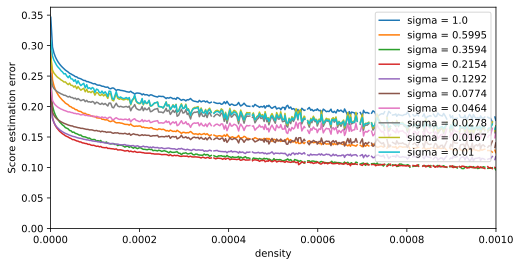

In [ ]:
plt.figure(figsize=(8,4))

for idx in range(10):

    densities_flat = densities.flatten()
    distances_flat = distances[idx].flatten()

    n_bins = 10000
    bin_edges = torch.linspace(densities_flat.min(), densities_flat.max(), n_bins+1)
    bin_idxs = torch.bucketize(densities_flat, bin_edges[1:])

    mean_dens = []
    mean_error = []
    for i in tqdm(range(n_bins)):
        idxs = torch.where(bin_idxs == i)[0]
        dens = densities_flat[idxs]
        dists = distances_flat[idxs]
        mean_dens.append(dens.mean().detach().numpy())
        mean_error.append(dists.mean().detach().numpy())

    # plt.plot(mean_dens, scipy.signal.medfilt(mean_error, kernel_size=61), label=f"{idx}")
    plt.plot(mean_dens, mean_error, label=f"sigma = {round(sigmas[idx].item(), 4)}")
    
plt.legend()
plt.xlim(0, 0.001)
plt.xlabel('density')
plt.ylabel('Score estimation error')
plt.savefig("diff_sigmas.png", dpi=300)

# **8.** Creation of the custom dataset for NCSM

Here is the provided code for the creation of the dataset used to retrain and test the NCSM of Song's work. Many changes have been made on the model  
(https://github.com/ermongroup/ncsn/tree/master?tab=readme-ov-file) but is not provided here because of the size of the files.

In [ ]:

# Function to create a triangle mask
def create_triangle_mask():
    vertices = np.array([[0, 28], [14, 0], [28, 28]])
    triangle_path = Path(vertices)
    mask = triangle_path.contains_points(np.column_stack((np.arange(28 * 28) % 28, np.arange(28 * 28) // 28)))
    return mask.reshape((28, 28))

def create_bar_mask(): 
    vertices = np.array([[11, 0], [17, 0], [11, 28], [17, 28]])
    triangle_path = Path(vertices)
    mask = triangle_path.contains_points(np.column_stack((np.arange(28 * 28) % 28, np.arange(28 * 28) // 28)))
    return mask.reshape((28, 28))

def create_circle_mask():
    center = (14, 14)
    radius = 8
    y, x = np.ogrid[:28, :28]
    mask = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2
    return mask.astype(np.uint8)

def create_square_mask():
    vertices = np.array([[8, 8], [20, 8], [20, 20], [8, 20]])
    square_path = Path(vertices)
    mask = square_path.contains_points(np.column_stack((np.arange(28 * 28) % 28, np.arange(28 * 28) // 28)))
    return mask.reshape((28, 28)).astype(np.uint8)

def create_swiss_roll_mask():
    x = np.arange(0, 28, 1)
    y = np.arange(0, 28, 1)
    x, y = np.meshgrid(x, y)
    mask = np.sin(np.sqrt((x - 14) ** 2 + (y - 14) ** 2)) * 10
    return (mask > 8).astype(np.uint8)

# Function to generate a random image with a triangle mask
def generate_random_image():
    random_array = np.random.randint(2, size=(28, 28))

    triangle_mask = create_triangle_mask()
    bar_mask = create_bar_mask()
    circle_mask = create_circle_mask()
    square_mask = create_square_mask()
    swiss_roll_mask = create_swiss_roll_mask()

    array_mask = [triangle_mask, bar_mask, circle_mask, square_mask, swiss_roll_mask]

    # Replace 1-values with random numbers between 170 and 258
    random_values = np.random.randint(170, 259, size=(28, 28))
    random_array[random_array == 1] = random_values[random_array == 1]

    rd1 = np.random.randint(15)
    if rd1 == 8 or rd1 == 9 :
        rd2 = np.random.randint(2)
        if rd2 == 0:
            rd = 0
        else :
            rd = 4
    else :
        rd = np.random.randint(1, 4)

    return random_array * array_mask[rd], rd
    

# Example usage:
num_images = 500

images=[]

for _ in range(num_images):
    image_data, label = generate_random_image()
    images.append(image_data)


(array([ 692.,    0., 2906.,    0.,    0., 2910.,    0., 2852.,    0.,
         640.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

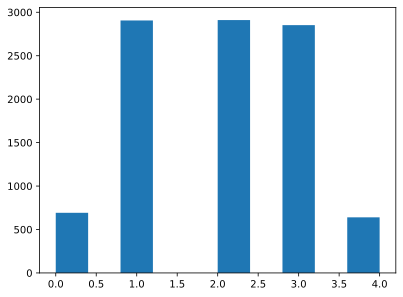

In [ ]:
# Distribution of teh data
a=[]
for i in range(10000):
    rd1 = np.random.randint(15)
    if rd1 == 8 or rd1 == 9 :
        rd2 = np.random.randint(2)
        if rd2 == 0:
            rd = 0
        else :
            rd = 4
    else :
        rd = np.random.randint(1, 4)

    a.append(rd)

plt.hist(a)

In [ ]:
import numpy as np
import struct

# Number of images to generate
num_images_train = 60000
num_images_test = 10000

folder_path = "./ncsn-master/run/datasets/custom_dataset/"
train_test = ["train", "test"]
train_test_num = [num_images_train, num_images_test]

for i, str_ in enumerate(train_test):
        
    # Create the binary file
    output_file = open(folder_path + str_ + "-images-idx3-ubyte", "wb")

    # Write the header information
    output_file.write(struct.pack(">I", 2051))  # Magic number
    output_file.write(struct.pack(">I", train_test_num[i]))  # Number of images
    output_file.write(struct.pack(">I", 28))  # Rows
    output_file.write(struct.pack(">I", 28))  # Columns

    # Generate and write each image
    for _ in range(train_test_num[i]):
        image_data, label = generate_random_image()
        image_data = image_data.astype(np.uint8)
        output_file.write(struct.pack("B", label))
        output_file.write(image_data.tobytes())

    # Close the file
    output_file.close()

    print("Images have been generated and saved.")

Images have been generated and saved.
Images have been generated and saved.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import struct

# class to be called in the NCSN code
class CustomDataset(Dataset):
    def __init__(self, root_folder, train=True):
        if train:
            filename = "/train-images-idx3-ubyte"
        else:
            filename = "/test-images-idx3-ubyte"
        self.images = self.read_images_idx3(root_folder + filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_data, label = self.images[idx]
        return torch.tensor(np.copy(image_data)).unsqueeze(0).float(), torch.tensor(label).float()

    def read_images_idx3(self, filename):
        with open(filename, 'rb') as f:
            # Read the header information
            magic_number = struct.unpack('>I', f.read(4))[0]
            num_images = struct.unpack('>I', f.read(4))[0]
            rows = struct.unpack('>I', f.read(4))[0]
            cols = struct.unpack('>I', f.read(4))[0]

            # Check if the file format is correct
            if magic_number != 2051:
                raise ValueError("Invalid magic number. This file may not be an IDX3 file.")

            images = []

            for _ in range(num_images):
                # Read the label and image data
                label = struct.unpack('B', f.read(1))[0]
                image_data = np.frombuffer(f.read(rows * cols), dtype=np.uint8)
                image_data = image_data.reshape((rows, cols))/256.

                images.append((image_data, label))

            return images

# Example usage:
root_folder = "./ncsn-master/run/datasets/custom_dataset/"
train_dataset = CustomDataset(root_folder, train=True)
test_dataset = CustomDataset(root_folder, train=False)

# Batch size for the DataLoader
batch_size = 128

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
